# Sixth Classifier

No age or image data, since those seem to be the explanatory variables the classifiers love the most.
We also leave out counts of incalls, outcalls, or "incalls and outcalls".

## Imports

In [1]:
from itertools import chain
import html
import ujson as json
import multiprocessing as mp
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold

from helpers import all_scoring_metrics
from helpers import draw_rocs

%matplotlib inline
sns.set(context='talk')

num_folds = 10
eval_columns = ['f1',
                'accuracy',
                'true_negative_rate',
                'true_positive_rate',
                'roc_auc',
                'roc_fpr',
                'roc_tpr',
                'roc_thresholds']
price_cols = ['duration_in_mins',
              'price',
              'price_per_min']

In [2]:
df = pd.read_pickle('../../data/merged/data_to_use_by_phone_v4.pkl')
print(df.shape)
print(df['class'].value_counts())

(567, 343)
False    508
True      59
Name: class, dtype: int64


In [3]:
id_cols = {'class', 'phone'}
price_cols = {x for x in df.columns if x.find('price') > -1}
duration_cols = {x for x in df.columns if x.find('duration') > -1}
flag_cols = {x for x in df.columns if x.find('flag_') > -1}
ethnicity_cols = {x for x in df.columns if x.find('ethnicity_') > -1}
image_cols = {x for x in df.columns if x.find('image') > -1}
age_cols = {x for x in df.columns if x.find('age') > -1} | set(['flag_Juvenile'])
service_cols = set(['n_incall', 'n_outcall', 'n_incall_and_outcall'])

In [4]:
etc = ExtraTreesClassifier(oob_score=True,
                           bootstrap=True,
                           random_state=2,
                           n_estimators=100,
                           n_jobs=-1,
                           class_weight="balanced")

rf = RandomForestClassifier(oob_score=True,
                            random_state=2,
                            n_estimators=100,
                            n_jobs=-1,
                            class_weight="balanced")

## Execution
Use both Random Forests and Extra Trees to classify the data using all columns

In [5]:
y_series = df['class']
X_df = df.loc[:, sorted(set(df.columns) - id_cols - age_cols - image_cols - service_cols)]
print(y_series.shape)
print(X_df.shape)

(567,)
(567, 276)


### Extra Trees

In [6]:
etc_metrics = all_scoring_metrics(etc, X_df, y_series, StratifiedKFold(y_series, num_folds))

In [7]:
this_metrics = etc_metrics
print(this_metrics.roc_auc.mean())
this_metrics.loc[:, ['f1', 'accuracy', 'true_negative_rate', 'true_positive_rate', 'roc_auc']]

0.780967320261438


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc
0,0.545455,0.912281,0.960784,0.500000,0.627451
1,0.307692,0.842105,0.901961,0.333333,0.696078
2,0.333333,0.789474,0.823529,0.500000,0.637255
3,0.187500,0.543860,0.549020,0.500000,0.568627
4,0.206897,0.596491,0.607843,0.500000,0.568627
5,0.500000,0.894737,0.941176,0.500000,0.905229
6,0.615385,0.912281,0.941176,0.666667,0.879085
7,0.545455,0.912281,0.960784,0.500000,0.967320
8,0.000000,0.892857,1.000000,0.000000,0.980000
9,0.833333,0.963636,0.960000,1.000000,0.980000


n_ads                                   0.074322
location_tree_length                    0.037202
missing_price_per_min:nmlzd_count       0.029066
incall_and_outcall:nmlzd_count          0.028723
missing_duration_in_mins:nmlzd_count    0.027813
missing_price:nmlzd_count               0.027622
flag_Traveling                          0.027463
incall:nmlzd_count                      0.026740
n_distinct_locations                    0.025705
flag_Foreign Providers                  0.024565
outcall:nmlzd_count                     0.023394
ethnicity_Ebony                         0.021940
missing_price:std                       0.021076
missing_duration_in_mins:std            0.020120
cooccurring_phones:nmlzd_count          0.019043
missing_price_per_min:std               0.018916
price:std                               0.014902
ethnicity_Dominican                     0.013404
ethnicity_White                         0.013394
flag_Multiple Girls                     0.012670
dtype: float64


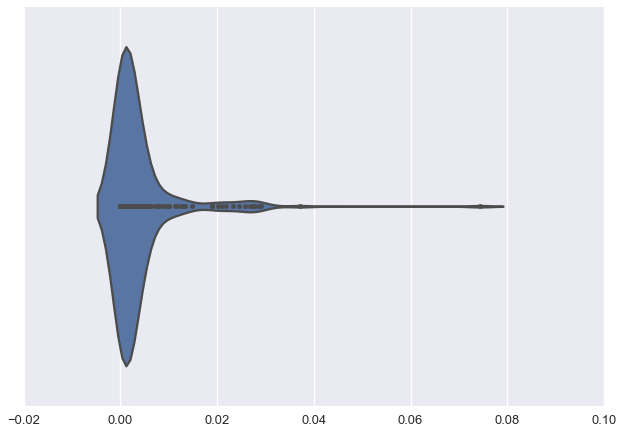

In [8]:
ranked_imptncs = this_metrics.loc[:,
                                  sorted(set(this_metrics.columns) - 
                                         set(eval_columns))].mean().sort_values(ascending=False)
print(ranked_imptncs.head(20))
sns.violinplot(ranked_imptncs, inner='point')

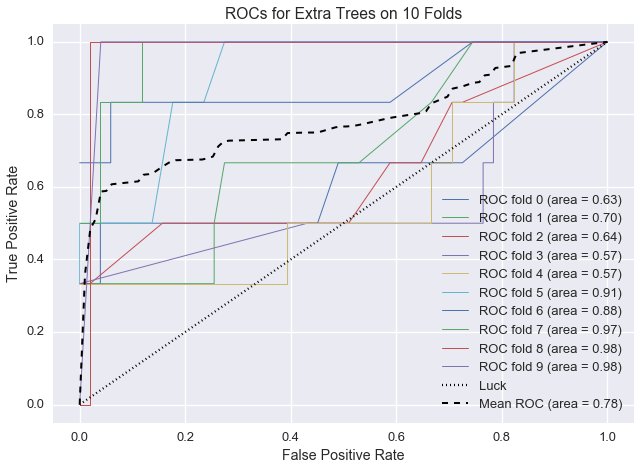

In [9]:
draw_rocs(this_metrics, 'Extra Trees')

### Random Forest

In [10]:
rf_metrics = all_scoring_metrics(rf, X_df, y_series, StratifiedKFold(y_series, num_folds))

In [11]:
this_metrics = rf_metrics
print(this_metrics.roc_auc.mean())
this_metrics.loc[:, ['f1', 'accuracy', 'true_negative_rate', 'true_positive_rate', 'roc_auc']]

0.7739411764705882


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc
0,0.400000,0.894737,0.960784,0.333333,0.645425
1,0.307692,0.842105,0.901961,0.333333,0.743464
2,0.333333,0.789474,0.823529,0.500000,0.612745
3,0.187500,0.543860,0.549020,0.500000,0.555556
4,0.206897,0.596491,0.607843,0.500000,0.542484
5,0.500000,0.894737,0.941176,0.500000,0.852941
6,0.666667,0.929825,0.960784,0.666667,0.870915
7,0.545455,0.912281,0.960784,0.500000,0.955882
8,0.000000,0.892857,1.000000,0.000000,1.000000
9,0.769231,0.945455,0.940000,1.000000,0.960000


n_ads                                   0.078456
missing_price:nmlzd_count               0.047250
missing_price_per_min:nmlzd_count       0.045885
missing_duration_in_mins:nmlzd_count    0.041892
location_tree_length                    0.036265
flag_Traveling                          0.029969
flag_Foreign Providers                  0.029657
incall_and_outcall:nmlzd_count          0.029112
cooccurring_phones:nmlzd_count          0.025483
n_distinct_locations                    0.023362
ethnicity_Ebony                         0.021284
incall:nmlzd_count                      0.020901
price:std                               0.020674
missing_price:std                       0.019051
outcall:nmlzd_count                     0.017339
missing_duration_in_mins:std            0.016531
flag_Multiple Girls                     0.015308
price:max                               0.014226
missing_price_per_min:std               0.012936
ethnicity_Latina                        0.012116
dtype: float64


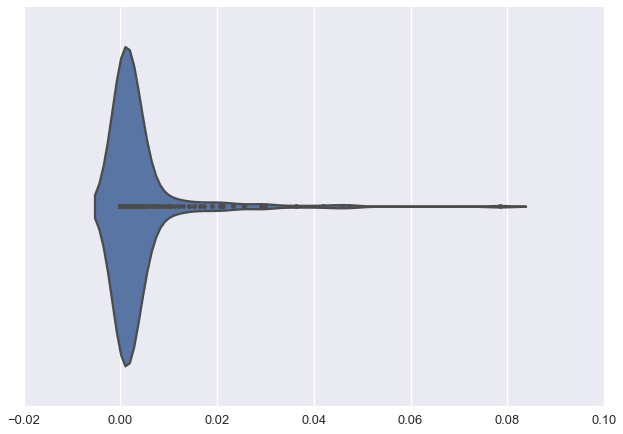

In [12]:
ranked_imptncs = this_metrics.loc[:,
                                  sorted(set(this_metrics.columns) - 
                                         set(eval_columns))].mean().sort_values(ascending=False)
print(ranked_imptncs.head(20))
sns.violinplot(ranked_imptncs, inner='point')

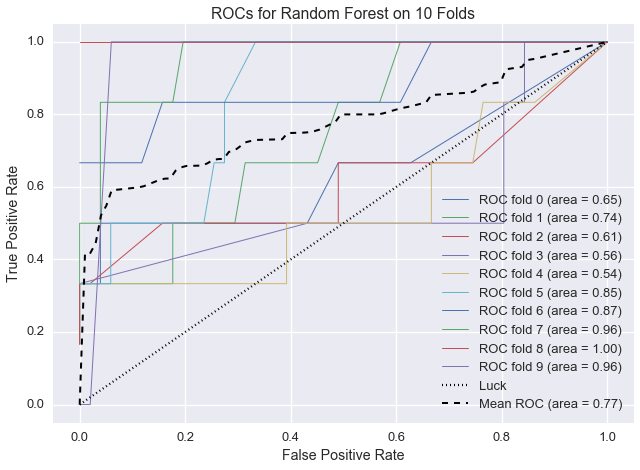

In [13]:
draw_rocs(this_metrics, 'Random Forest')